In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.animation as animation

from FyeldGenerator import generate_field
import scipy.stats as st

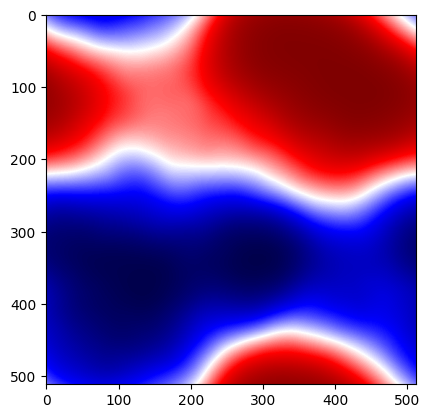

In [20]:
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)

    return Pk


# Draw samples from a normal distribution
def distrib(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b


shape = (512, 512)

field = generate_field(distrib, Pkgen(7), shape)
z_field = (field-np.mean(field))/np.std(field)
perc_field= st.norm.cdf(z_field)


plt.imshow(perc_field, cmap="seismic")

In [9]:
np.mean(field)

-3.410605131648481e-13

In [10]:
np.std(field)

27170.588059602604

In [14]:
test_f = (field-np.mean(field))/np.std(field)

In [22]:
test_p = st.norm.cdf(test_f)

In [24]:
test_p.shape

(512, 512)

In [25]:
np.random.binomial(n=1, p=test_p, size=test_p.shape)

array([[1, 0, 0, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 1, 1],
       [0, 1, 0, ..., 1, 1, 1],
       ...,
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 0]])

In [38]:
class ConwaysGame:

    def __init__(self, grid_size=(100,100), grid_type='grf', prob_if_0 = [0,0,0,1.0,0,0,0,0,0], prob_if_1=[0,0,1.0,1.0,0,0,0,0,0]):
        """

        grid_size: 2D tuple defining size of grid life is playing on
        prob_if_0: list of bernoulli probabilities where the ith element of the list represents the probability for 
            drawing a bernoulli yes if a cell with a 0 value has i neighbors with a 1 value.
        prob_if_1: list of bernoulli probabilities where the ith element of the list represents the probability for 
            drawing a bernoulli yes if a cell with a 1 value has i neighbors with a 1 value
        """
        self.prob_if_0 = prob_if_0
        self.prob_if_1 = prob_if_1
        self.grid_size = grid_size
        self.grid_l = grid_size[0] # up / down
        self.grid_w = grid_size[1] 
        self.init_grid(grid_type=grid_type)


    def init_grid(self, grid_type):
        np.random.seed(42069)
        if grid_type == 'uniform_rand':
            p_ones = 0.4
            self.grid = np.random.choice([0,1], self.grid_size, p=((1-p_ones),p_ones)) # seed random start 
        if grid_type == 'grf':
            self.gen_corr_probability_field() # creates self.grid_init_prob_field
            self.grid = np.random.binomial(n=1, p=self.grid_init_prob_field, size=self.grid_size)
        # something to add: a situation where a gaussian random field sets the seed probability as a function of space!
        
        
        
        self.grids = []
        self.grids.append(self.grid)

    def gen_corr_probability_field(self):
        """
        uses random fields to generate a spatially correlated field of bernoulli probabilities, one probability per grid cell, 
        which we'll use to draw an initial grid of 1s and 0s for conway's game
        """
        def Pkgen(n):
            def Pk(k):
                return np.power(k, -n)
        
            return Pk
        
        
        # Draw samples from a normal distribution
        def distrib(shape):
            a = np.random.normal(loc=0, scale=1, size=shape)
            b = np.random.normal(loc=0, scale=1, size=shape)
            return a + 1j * b
        
        
        shape = (self.grid_l, self.grid_w)
        
        field = generate_field(distrib, Pkgen(7), shape) # 7 just because I like the grouping effect
        z_field = (field-np.mean(field))/np.std(field)
        prob_field= st.norm.cdf(z_field)
        self.grid_init_prob_field = prob_field

    def lookup_neighbor_vals(self, i,j):
        # return right index
        neighbors_list = []

        # determining what the i and j coords of neighbors are given a periodic wrap-around space
        if i == 0:
            i_up = self.grid_l - 1
            i_down = i+1
        elif i == self.grid_l - 1:
            i_up = i - 1
            i_down = 0
        else:
            i_up = i - 1
            i_down = i + 1

        if j == 0:
            j_left = self.grid_w - 1
            j_right = j+1
        elif j == self.grid_w - 1:
            j_left = j - 1
            j_right = 0
        else:
            j_left = j - 1
            j_right = j + 1
            
        neighbor_indices = [[i_down,j], [i_up,j],[i,j_right],[i,j_left],[i_down, j_right],[i_down,j_left],[i_up,j_right],[i_up,j_left]]
        for neighbor in neighbor_indices:
            n_val = self.grid[neighbor[0], neighbor[1]]
            neighbors_list.append(n_val)
        return neighbors_list
        


    def update_cell(self, cell_i, cell_j):
        cell_val = self.grid[cell_i, cell_j]
        neighbor_vals = self.lookup_neighbor_vals(cell_i, cell_j)
        total_neighbors = int(np.sum(neighbor_vals))
        if cell_val==0:
            new_val = np.random.binomial(1, self.prob_if_0[total_neighbors])
        elif cell_val==1:
            new_val = np.random.binomial(1, self.prob_if_1[total_neighbors])
        return new_val

    def update_grid(self):
        new_grid = np.zeros(self.grid_size)
        self.track_ids = []
        for i in range(0, self.grid_l):
            for j in range(0, self.grid_w):
                self.track_ids.append([i,j])
                new_grid[i,j] = self.update_cell(i,j)
        self.grid = new_grid
        self.grids.append(self.grid)

    def run_game_for_x_turns(self, x=160):
        for i in range(0, x):
            self.update_grid()
        self.turns = x

    def visualize_game(self, save=False):
        N_plots= self.turns
        fig,ax = plt.subplots(figsize=(12,12))
        
        ims = []
        for i in range(0,N_plots):
            im = ax.matshow(game_obj.grids[i], animated=True)
            ims.append([im])
        ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                        repeat_delay=1000)
        writergif = animation.PillowWriter(fps=3) 
        if save:
            ani.save("prob_gol.gif", writer=writergif)
                
        
    
        





In [39]:
game_obj = ConwaysGame(prob_if_0 = [0,0,0,1,0,0,0,0,0], prob_if_1=[0,0,1,1,0,0,0,0,0])



In [40]:
game_obj.run_game_for_x_turns(x=150)

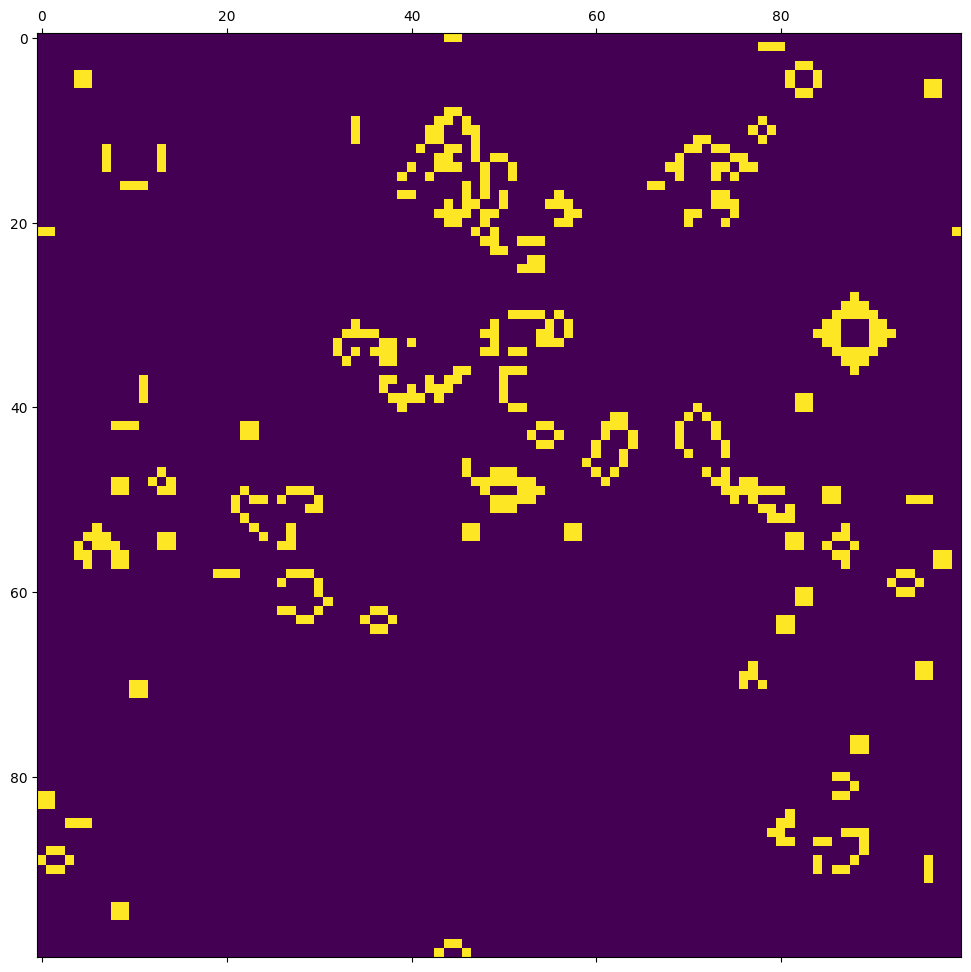

In [41]:
game_obj.visualize_game(save=True)